## Installing all dependencies

In [ ]:
import torch

In [ ]:

import os

os.environ['TORCH'] = torch.__version__
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

!pip install sentence_transformers

Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.1+cu121.html
ERROR: Could not find a version that satisfies the requirement pyg-lib (from versions: none)
ERROR: No matching distribution found for pyg-lib
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-qekfu1v2
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-qekfu1v2
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 68a0dd12d72f3ba35df20531d85d178d10ffcf5d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sentence_transformers-2.5.1-py3-none-any.whl (156 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading the Dataset (MovieLens)

We are using the ml-latest-small dataset

In [ ]:
from torch_geometric.data import download_url, extract_zip
import pandas as pd


url = f'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

extract_zip(download_url(url, '.'), '.')

Extracting ./ml-latest-small.zip


In [ ]:
movies_path = f'./ml-latest-small/movies.csv'

ratings_path = f'./ml-latest-small/ratings.csv'

In [ ]:
# Loading the movies data
movies_df = pd.read_csv(movies_path)

display(movies_df)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
# Movies data information
print(f"Number of movies in dataset: {len(movies_df)}")
print(f"Number of genres in dataset: {len(movies_df['genres'].unique())}")

Number of movies in dataset: 9742
Number of genres in dataset: 951


In [ ]:
ratings_df = pd.read_csv(ratings_path)

In [ ]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
users = ratings_df["userId"]
users = set(users)
print(f"Number of users: {len(users)}")

Number of users: 610


In [ ]:
ratings = ratings_df["rating"]
no_of_ratings = len(ratings)
print(f"Number of ratings: {len(ratings)}")

Number of ratings: 100836


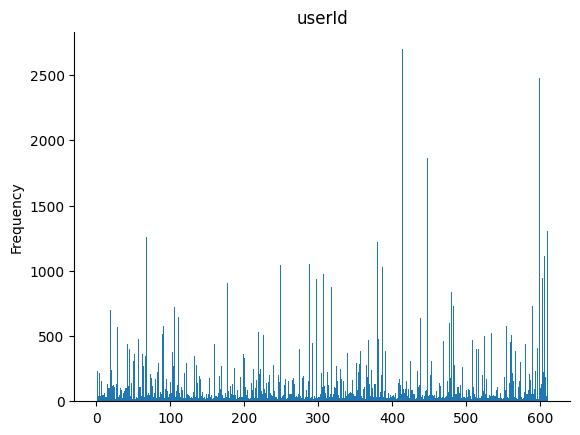

In [ ]:
from matplotlib import pyplot as plt
ratings_df['userId'].plot(kind='hist', bins=610, title='userId')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Generating Embeddings movies.

Using BERT to generate embedding for movive title.

In [ ]:
import numpy as np
import torch
from sentence_transformers import SentenceTransformer

# One-hot encoding (genres)
genres = movies_df['genres'].str.get_dummies('|').values
genres = torch.from_numpy(genres).to(torch.float)


# Pretrained sentence transformer
model = SentenceTransformer('all-MiniLM-L6-v2')
with torch.no_grad():
    titles = model.encode(movies_df['title'].tolist(), convert_to_tensor=True, show_progress_bar=True)
    titles = titles.cpu()

# Creating movie feature vector by concatenating the genres and title features
movie_features = torch.cat([genres, titles], dim=-1)


# Users are represnted using identity matrix
user_features = torch.eye(len(ratings_df['userId'].unique()))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/305 [00:00<?, ?it/s]

In [ ]:
print(f"Size of each movie embedding is: {len(movie_features[0])}")

Size of each movie embedding is: 404


In [ ]:
print(f"movie_features: {len(movie_features)}")

movie_features: 9742


In [ ]:
print(f"user_features: {user_features.shape}")

user_features: torch.Size([610, 610])


In [ ]:
# Mapping the user_id to a unique consecutive value
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedUserId': pd.RangeIndex(len(unique_user_id))
    })

print(f"unique_user_id length {len(unique_user_id)}")

unique_user_id length 610


In [ ]:
# Mapping the movie_id to a unique consecutive value
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedMovieId': pd.RangeIndex(len(unique_movie_id))
    })

print(f"{unique_movie_id}")
print(f"Length: {len(unique_movie_id)}")

      movieId  mappedMovieId
0           1              0
1           3              1
2           6              2
3          47              3
4          50              4
...       ...            ...
9719   160341           9719
9720   160527           9720
9721   160836           9721
9722   163937           9722
9723   163981           9723

[9724 rows x 2 columns]
Length: 9724


In [ ]:
# Merging these ids to the original dataframe
ratings_df = ratings_df.merge(unique_user_id, on='userId')
ratings_df = ratings_df.merge(unique_movie_id, on='movieId')

In [ ]:
ratings_df

,userId,movieId,rating,timestamp,mappedUserId,mappedMovieId
0,1,1,4.0,964982703,0,0
1,5,1,4.0,847434962,4,0
2,7,1,4.5,1106635946,6,0
3,15,1,2.5,1510577970,14,0
4,17,1,4.5,1305696483,16,0
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,609,9719
100832,610,160527,4.5,1479544998,609,9720
100833,610,160836,3.0,1493844794,609,9721
100834,610,163937,3.5,1493848789,609,9722


In [ ]:
# Selecting one user to study
user_0 = ratings_df[ratings_df["mappedUserId"] == 0]
user_0

,userId,movieId,rating,timestamp,mappedUserId,mappedMovieId
0,1,1,4.0,964982703,0,0
215,1,3,4.0,964981247,0,1
267,1,6,4.0,964982224,0,2
369,1,47,5.0,964983815,0,3
572,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
16056,1,3744,4.0,964980694,0,227
16075,1,3793,5.0,964981855,0,228
16208,1,3809,4.0,964981220,0,229
16243,1,4006,4.0,964982903,0,230


In [ ]:
# Storing the ratings of user 0 to test after training model

user_0_prefs= user_0[1:11]
user_0_prefs

,userId,movieId,rating,timestamp,mappedUserId,mappedMovieId
215,1,3,4.0,964981247,0,1
267,1,6,4.0,964982224,0,2
369,1,47,5.0,964983815,0,3
572,1,50,5.0,964982931,0,4
776,1,70,3.0,964982400,0,5
831,1,101,5.0,964980868,0,6
854,1,110,4.0,964982176,0,7
1091,1,151,5.0,964984041,0,8
1135,1,157,5.0,964984100,0,9
1146,1,163,5.0,964983650,0,10


In [ ]:
for i in range(11):
  ratings_df.drop(ratings_df[(ratings_df['mappedUserId'] == 0) & (ratings_df['mappedMovieId'] == i)].index, inplace=True)


In [ ]:
sorted= ratings_df.sort_values(by="mappedUserId")
sorted[0:100]

,userId,movieId,rating,timestamp,mappedUserId,mappedMovieId
15452,1,3448,5.0,964984054,0,214
11437,1,2139,5.0,964982791,0,137
11458,1,2141,5.0,964982838,0,138
11476,1,2143,4.0,964981725,0,139
11489,1,2161,5.0,964981710,0,140
...,...,...,...,...,...,...
15039,1,3062,4.0,964981872,0,202
9889,1,1617,5.0,964982951,0,103
15028,1,3053,5.0,964984086,0,201
14913,1,3034,5.0,964982791,0,199


In [ ]:

ratings_df[(ratings_df['mappedUserId'] == 0) & (ratings_df['mappedMovieId'] == 1)]

,userId,movieId,rating,timestamp,mappedUserId,mappedMovieId


In [ ]:
ratings_df

,userId,movieId,rating,timestamp,mappedUserId,mappedMovieId
1,5,1,4.0,847434962,4,0
2,7,1,4.5,1106635946,6,0
3,15,1,2.5,1510577970,14,0
4,17,1,4.5,1305696483,16,0
5,18,1,3.5,1455209816,17,0
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,609,9719
100832,610,160527,4.5,1479544998,609,9720
100833,610,160836,3.0,1493844794,609,9721
100834,610,163937,3.5,1493848789,609,9722


In [ ]:
# Creating a edge index representation to load the data into PyG graph
edge_index = torch.stack([
    torch.tensor(ratings_df['mappedUserId'].values),
    torch.tensor(ratings_df['mappedMovieId'].values)]
    , dim=0)

# edge_index matrix should have the shape [2, num_ratings]
print(f"{edge_index.shape}")

torch.Size([2, 100825])


## Creating a PyG graph with the data

In [ ]:
import torch_geometric.transforms
from torch_geometric.data import HeteroData

# Creating a heterogeneous graph object
data = HeteroData()

# Adding user nodes
data['user'].x = user_features  # [num_users, num_features_users]

# Adding the movie nodes:
data['movie'].x = movie_features  # [num_movies, num_features_movies]

# Adding the edges( User --> Movie)
data['user', 'rates', 'movie'].edge_index = edge_index  # [2, num_ratings]

# Rating Values
rating = torch.from_numpy(ratings_df['rating'].values).to(torch.float)
data['user', 'rates', 'movie'].edge_label = rating  # [num_ratings]

# Adding reverse edges (Movie --> User)
data = torch_geometric.transforms.ToUndirected()(data)

# Removing reversed labels
del data['movie', 'rev_rates', 'user'].edge_label

data

HeteroData(
  user={ x=[610, 610] },
  movie={ x=[9742, 404] },
  (user, rates, movie)={
    edge_index=[2, 100825],
    edge_label=[100825],
  },
  (movie, rev_rates, user)={ edge_index=[2, 100825] }
)

In [ ]:
data.edge_items()[0]

(('user', 'rates', 'movie'),
 {'edge_index': tensor([[   4,    6,   14,  ...,  609,  609,  609],
         [   0,    0,    0,  ..., 9721, 9722, 9723]]), 'edge_label': tensor([4.0000, 4.5000, 2.5000,  ..., 3.0000, 3.5000, 3.5000])})

In [ ]:
data.edge_items()[0][1].edge_index

tensor([[   4,    6,   14,  ...,  609,  609,  609],
        [   0,    0,    0,  ..., 9721, 9722, 9723]])

In [ ]:
data.edge_items()[0][1].edge_label[0].item()

4.0

In [ ]:
# User representation
data['user'].x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [ ]:
user_tensor = data['user'].x
type(user_tensor[0][0])
user_tensor[0][0]

tensor(1.)

In [ ]:
# Movie representation
print(data['movie'].x)
print(data['movie'].x.shape)

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  ...,  2.2616e-02,
          5.3814e-02,  1.0297e-01],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  ...,  1.0561e-02,
         -7.2631e-02,  8.6105e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.2006e-02,
          3.0255e-02,  4.1655e-04],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.4684e-02,
          2.9905e-02,  2.0007e-02],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ..., -5.1593e-02,
         -1.4267e-02,  1.0123e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.1982e-02,
          5.4629e-02, -2.7146e-02]])
torch.Size([9742, 404])


In [ ]:
train_data, val_data, test_data = torch_geometric.transforms.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)
train_data, val_data

(HeteroData(
   user={ x=[610, 610] },
   movie={ x=[9742, 404] },
   (user, rates, movie)={
     edge_index=[2, 80661],
     edge_label=[80661],
     edge_label_index=[2, 80661],
   },
   (movie, rev_rates, user)={ edge_index=[2, 80661] }
 ),
 HeteroData(
   user={ x=[610, 610] },
   movie={ x=[9742, 404] },
   (user, rates, movie)={
     edge_index=[2, 80661],
     edge_label=[10082],
     edge_label_index=[2, 10082],
   },
   (movie, rev_rates, user)={ edge_index=[2, 80661] }
 ))

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=32).to(device)

print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv((-1, -1), 32, aggr=mean)
      (movie__rev_rates__user): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv((-1, -1), 32, aggr=mean)
      (movie__rev_rates__user): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    data = data.to(device)
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

total_loss = []
for epoch in range(1, 301):
    train_data = train_data.to(device)
    loss = train()
    total_loss.append(loss)
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}')


Epoch: 001, Loss: 0.7310, Train: 0.8553, Val: 0.8940
Epoch: 002, Loss: 0.7319, Train: 0.8631, Val: 0.9075
Epoch: 003, Loss: 0.7451, Train: 0.8551, Val: 0.8963
Epoch: 004, Loss: 0.7314, Train: 0.8578, Val: 0.8947
Epoch: 005, Loss: 0.7363, Train: 0.8590, Val: 0.8953
Epoch: 006, Loss: 0.7385, Train: 0.8555, Val: 0.8939
Epoch: 007, Loss: 0.7323, Train: 0.8550, Val: 0.8961
Epoch: 008, Loss: 0.7312, Train: 0.8573, Val: 0.8999
Epoch: 009, Loss: 0.7351, Train: 0.8572, Val: 0.8998
Epoch: 010, Loss: 0.7350, Train: 0.8552, Val: 0.8967
Epoch: 011, Loss: 0.7316, Train: 0.8546, Val: 0.8942
Epoch: 012, Loss: 0.7307, Train: 0.8558, Val: 0.8939
Epoch: 013, Loss: 0.7328, Train: 0.8562, Val: 0.8940
Epoch: 014, Loss: 0.7335, Train: 0.8552, Val: 0.8938
Epoch: 015, Loss: 0.7317, Train: 0.8545, Val: 0.8946
Epoch: 016, Loss: 0.7304, Train: 0.8550, Val: 0.8964
Epoch: 017, Loss: 0.7313, Train: 0.8557, Val: 0.8975
Epoch: 018, Loss: 0.7323, Train: 0.8553, Val: 0.8969
Epoch: 019, Loss: 0.7317, Train: 0.8545, Val: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "drive/MyDrive/CS 247 Project/ml-100k"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_test = Model(hidden_channels=32)
model.load_state_dict(torch.load("/content/drive/MyDrive/CS 247 Project/model/model.pt"))
model.eval()

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv((-1, -1), 32, aggr=mean)
      (movie__rev_rates__user): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv((-1, -1), 32, aggr=mean)
      (movie__rev_rates__user): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
# Loading Pre-Trained model

# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

[0.7309513092041016, 0.7319275736808777, 0.7450863718986511, 0.7314149737358093, 0.7363309264183044, 0.7385478615760803, 0.7322532534599304, 0.7312158346176147, 0.7350525856018066, 0.7349894046783447, 0.7316478490829468, 0.7306607961654663, 0.73277747631073, 0.7335355877876282, 0.7317003607749939, 0.7304139733314514, 0.7313058972358704, 0.7323469519615173, 0.7317100763320923, 0.7304990291595459, 0.7305012941360474, 0.7313514947891235, 0.7314016222953796, 0.7305777668952942, 0.7302131652832031, 0.730681836605072, 0.7309719920158386, 0.7305413484573364, 0.7301052212715149, 0.7302792072296143, 0.7305760979652405, 0.7303826808929443, 0.7300217747688293, 0.7300499081611633, 0.7302668690681458, 0.7301841974258423, 0.7299166917800903, 0.7298867106437683, 0.7300299406051636, 0.7299813032150269, 0.729785680770874, 0.7297503352165222, 0.7298370599746704, 0.7297886610031128, 0.7296439409255981, 0.7296175956726074, 0.7296633720397949, 0.7296029329299927, 0.729494035243988, 0.7294797301292419, 0.72

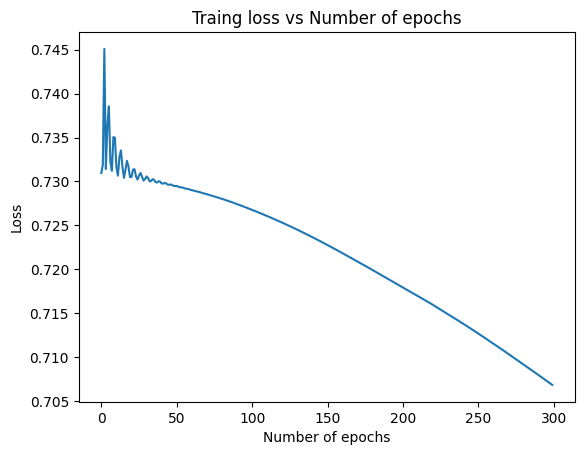

In [ ]:
print(total_loss)
from matplotlib import pyplot as plt

epochs = [x for x in range(300)]
len(epochs)

plt.plot(epochs, total_loss, label="train loss")
plt.title("Traing loss vs Number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

print(max(total_loss))

## Evaluating the model

In [ ]:
with torch.no_grad():
    test_data = test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = test_data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

userId = test_data['user', 'movie'].edge_label_index[0].cpu().numpy()
movieId = test_data['user', 'movie'].edge_label_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

print(pd.DataFrame({'userId': userId, 'movieId': movieId, 'rating': pred, 'target': target}))

Test RMSE: 0.8915
       userId  movieId    rating  target
0         411      154  3.519424     3.0
1         181     2936  3.174636     2.5
2         334     1593  3.586422     3.0
3          95      463  3.851281     5.0
4         589     1681  2.985158     2.5
...       ...      ...       ...     ...
10077     481     1890  3.237957     4.0
10078      46     2049  3.171032     4.0
10079      41     2618  3.074436     4.0
10080     447     6556  3.333894     1.0
10081     136     1469  2.712097     3.0

[10082 rows x 4 columns]


## Movie Rating Prediction

In [ ]:
# User we want to predict for
mapped_user_id = 0

In [ ]:
edge_label_index = torch.tensor([
    mapped_user_id,
   4])

with torch.no_grad():
    test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict, edge_label_index)
    pred = pred.clamp(min=0, max=5).detach().cpu().numpy()

In [ ]:
pred.item()

5.0